# Text classification







The task concentrates on classification of sentence pairs.







This type of classification is useful for problems such as determining the similarity of sentences or



checking if a text passage contains an answer to a question.

In [1]:
!pip install datasets
!pip install sacremoses
!pip install transformers[torch]
!pip install torch
!pip install evaluate

zsh:1: no matches found: transformers[torch]


Imports

In [10]:
import pandas as pd
import random
import pyarrow as pa
import evaluate
import numpy as np
from datasets import load_dataset
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import pipeline
from sklearn.model_selection import train_test_split
from elasticsearch import Elasticsearch
from tqdm import tqdm

## Tasks

Objectives (8 points):

1. Use the FIQA-PL dataset that was used in lab 1 **and** lab lab 2 (so we need the passages, the questions and their relations).

In [ ]:
dataset = load_dataset("clarin-knext/fiqa-pl", 'corpus')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/201 [00:00<?, ?B/s]

fiqa-pl.py:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/57638 [00:00<?, ? examples/s]

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 57638
    })
})

In [ ]:
df=pd.DataFrame(dataset['corpus'])
df

,_id,title,text
0,3,,"Nie mówię, że nie podoba mi się też pomysł szk..."
1,31,,Tak więc nic nie zapobiega fałszywym ocenom po...
2,56,,Nigdy nie możesz korzystać z FSA dla indywidua...
3,59,,Samsung stworzył LCD i inne technologie płaski...
4,63,,Oto wymagania SEC: Federalne przepisy dotycząc...
...,...,...,...
57633,599946,,">Cóż, po pierwsze, drogi to coś więcej niż hob..."
57634,599953,,"Tak, robią. Na dotacje dla firm farmaceutyczny..."
57635,599966,,">To bardzo smutne, że nie rozumiesz ludzkiej n..."
57636,599975,,„Czy Twój CTO pozwolił dużej grupie użyć „„adm...


In [ ]:
df2 = load_dataset("clarin-knext/fiqa-pl-qrels")
df_qa_train = pd.DataFrame(df2['train'])

README.md:   0%|          | 0.00/201 [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/210k [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14166 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1238 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1706 [00:00<?, ? examples/s]

In [ ]:
df3 = load_dataset("clarin-knext/fiqa-pl", "queries")
df_queries = pd.DataFrame(df3['queries'])

0000.parquet:   0%|          | 0.00/377k [00:00<?, ?B/s]

Generating queries split:   0%|          | 0/6648 [00:00<?, ? examples/s]

2. Create a dataset of positive and negative sentence pairs.
   1. In each pair the first element is a question and the second element is a passagei, i.e. "{question} {separator} {passage}", where `separator` should be a separator taken from the model's tokenizer.
   2. Use the relations to mark the positive pairs (i.e. pairs where the question is answered by the passage).
   3. Use your own strategy to mark negative pairs (i.e. you can draw the negative examples, but there are better strategies to define the negative examples). The number of negative examples should be larger than the number of positive examples.

In [ ]:
df_qa_train['query-id'] = df_qa_train['query-id'].astype(str)
df_qa_train['corpus-id'] = df_qa_train['corpus-id'].astype(str)

In [ ]:
results = pd.merge(df_queries, df_qa_train, left_on='_id', right_on='query-id')
results = pd.merge(results, df, left_on='corpus-id', right_on='_id')
new_df = results[['text_x', 'text_y', 'score']]

In [ ]:
new_df = new_df.rename(columns={'text_x': 'query', 'text_y': 'text', 'score': 'class'})
new_df = new_df.sample(frac=1).reset_index(drop=True)
new_df

,query,text,class
0,Co dzieje się z kontraktem opcyjnym podczas ca...,"Zależy od Twojej umowy, gotówki lub dostarczon...",1
1,Imię mojej matki widnieje na tytule mojego sam...,"To jej samochód. W przeciwieństwie do tego, co...",1
2,Nowicjusz w inwestowaniu — mam zaoszczędzone 2...,Moja rada dla ciebie to nie brać od nikogo żad...,1
3,"Czy powinienem sprzedawać, gdy moje zapasy rosną?","Jeśli czujesz się komfortowo, zyskując 8% na s...",1
4,Co właściwie oznacza stopa inflacji x%?,"„Powiedzmy, że w lipcu jest produkt wart 10 US...",1
...,...,...,...
14161,Jeśli przyjmę więcej niż 10 000 USD w gotówce ...,„Płacenie podatku to Dobra Rzecz. Jednak Warre...,1
14162,Dlaczego tworzone są opcje?,„W ogólnej teorii ekonomii zawsze istnieją dwa...,1
14163,Superogólny typ funduszu inwestycyjnego,Ponieważ masz już dwukrotnie swój cel w tym fu...,1
14164,Dlaczego płynność oznacza wąski spread i niski...,Teoretycznie jest to kwestia stopy zwrotu. Jeś...,1


In [ ]:
columns = ['query', 'text', 'class']
new_df_2 = pd.DataFrame(columns=columns)

In [ ]:
for query_id in df_qa_train['query-id'].unique():
    corpus_list = list(df_qa_train[df_qa_train['query-id'] == str(query_id)]['corpus-id'])
    for i in range(len(corpus_list)):
        corpus_id = random.choice(df['_id'])
        if str(corpus_id) in corpus_list:
            i -= 1
            continue

        new_row = {
            'query': df_queries[df_queries['_id'] == str(query_id)]['text'].values[0],
            'text': df[df['_id'] == str(corpus_id)]['text'].values[0],
            'class': 0
        }

        new_df_2 = pd.concat([new_df_2, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
new_df_2 = new_df_2.sample(frac=1).reset_index(drop=True)
new_df_2

,query,text,class
0,"Czy warto pracować w domu, żeby zarabiać pieni...","* Wykorzystuje statystyki, aby wprowadzać w bł...",0
1,"Powody, dla których wartość wewnętrzna i cena ...","Spierałbym się o inny rodzaj loterii, o którym...",0
2,Jakie działania mogę podjąć wobec banku z powo...,Obama chciał zabrać twoją broń. Trump chce cię...,0
3,Na jaką korzyść podatkową powinienem zwracać u...,Telefon zostanie ponownie uruchomiony jako Ice...,0
4,Praca dla rekrutera na W-2 czy praca dla klien...,„Jestem klientem. Chcę tylko minimalnej obsług...,0
...,...,...,...
14160,Co dzieje się z osobami bez oszczędności emery...,"„Wydaje się, że traktujesz swoją Roth IRA jako...",0
14161,Plusy i minusy na Węgrzech inwestowania oszczę...,"„Ten artykuł wygląda tak, jakby to wina osoby,...",0
14162,Czy moje konta 401k/Roth korzystają z kapitali...,„Spójrz na szerszą dywersyfikację. Coś takiego...,0
14163,Wykresy cen: dlaczego nie zmiana procentowa?,To powinno być prawnie zabronione! A jeśli ist...,0


In [ ]:
final_df = pd.concat([new_df[:2000],new_df_2[:10000]], axis=0)
final_df = final_df.sample(frac=1).reset_index(drop=True)
final_df

,query,text,class
0,Jak działa zasada dotycząca zapasów zastępczyc...,"FYI, mam 20 lat. I albo naprawdę trollingujesz...",0
1,Jaka jest różnica między akcjami a obligacjami?,"„Nie powiedziałem, że gospodarka nie ma się do...",0
2,Dlaczego nie każda firma i osoba fizyczna korz...,#####&#009; ######&#009; ####&#009; [**Prawo B...,0
3,Które usługi online oferują wykresy logarytmic...,"„Wykresy na nasdaq.com są oparte na logach, je...",1
4,W jaki sposób zmiany stóp procentowych wpłyną ...,"Myślę, że najpierw powinieneś przeczytać opis ...",0
...,...,...,...
11995,Czy ktoś może wytłumaczyć cenę akcji „kupuj” i...,Kushagra Bajaj jest Wspólnym Dyrektorem Zarząd...,0
11996,Negatywy na zwiększony limit wydatków na karci...,"„Rozwiązałem quiz, do którego również podałeś ...",0
11997,"Jak to się dzieje, że rząd może wycenić dom wy...",">Mad Men, LOST, Walking Dead, Game of Thrones ...",0
11998,30% udziału w biznesie,"Jeśli sprzedałeś kupioną opcję kupna, to, jak ...",0


In [ ]:
final_df['text'] = final_df.apply(lambda row: f"Pytanie: {row['query']} Kontekst: {row['text']}", axis=1)
final_df = final_df.drop(['query'], axis=1)
final_df

,text,class
0,Pytanie: Jak działa zasada dotycząca zapasów z...,0
1,Pytanie: Jaka jest różnica między akcjami a ob...,0
2,Pytanie: Dlaczego nie każda firma i osoba fizy...,0
3,Pytanie: Które usługi online oferują wykresy l...,1
4,Pytanie: W jaki sposób zmiany stóp procentowyc...,0
...,...,...
11995,Pytanie: Czy ktoś może wytłumaczyć cenę akcji ...,0
11996,Pytanie: Negatywy na zwiększony limit wydatków...,0
11997,"Pytanie: Jak to się dzieje, że rząd może wycen...",0
11998,Pytanie: 30% udziału w biznesie Kontekst: Jeśl...,0


3. The dataset from point 2 should be split into training, evaluation and testing subsets.

In [ ]:
df=final_df

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')

tokenizer_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/907k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/556k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

In [ ]:
def process_data(row):
    text = row['text']
    text = str(text)
    text = ' '.join(text.split())
    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    encodings['label'] = row['class']
    encodings['text'] = text

    return encodings

In [ ]:
processed_data = []

for i in range(len(df)):
    processed_data.append(process_data(df.iloc[i]))

In [ ]:
new_df = pd.DataFrame(processed_data)
train_df, valid_df = train_test_split(new_df,test_size=0.2,random_state=42)
train_df, test_df = train_test_split(train_df,test_size=0.2,random_state=42)

In [ ]:
train = Dataset(pa.Table.from_pandas(train_df))
valid = Dataset(pa.Table.from_pandas(valid_df))
test = Dataset(pa.Table.from_pandas(test_df))

4. Train a text classifier using the Transformers library that distinguishes between the positive and the negative
   pairs. To make the process manageable use models of size `base` and a runtime providing GPU/TPU acceleration.
   Consult the discussions related to fine-tuning Transformer models to select sensible set of parameters.
   You can also run several trainings with different hyper-parameters, if you have access to large computing resources.

5. Make sure you monitor the relevant metrics on the validation set during training. The last saved model might not be the



   one with the best performance.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('allegro/herbert-base-cased',num_labels=2)

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./output",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    eval_steps=300,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-05,
    num_train_epochs=10,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="steps",
    save_steps=300,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=valid,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

<ipython-input-23-5e99c259e20a>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
300,0.252800,0.212939,0.910417,0.920000,0.512376,0.658188
600,0.170500,0.219838,0.929167,0.796954,0.777228,0.786967
900,0.239300,0.225917,0.933750,0.821522,0.774752,0.797452
1200,0.106000,0.344556,0.927917,0.902439,0.641089,0.749638
1500,0.057600,0.390268,0.933333,0.831522,0.757426,0.792746
1800,0.074300,0.348632,0.927500,0.771226,0.809406,0.789855
2100,0.044200,0.452444,0.930000,0.780952,0.811881,0.796117
2400,0.050900,0.404597,0.929167,0.823204,0.737624,0.778068
2700,0.032400,0.492201,0.929583,0.866044,0.688119,0.766897
3000,0.008700,0.524479,0.932083,0.830137,0.750000,0.788036


TrainOutput(global_step=4800, training_loss=0.07082748450341265, metrics={'train_runtime': 2259.3299, 'train_samples_per_second': 33.992, 'train_steps_per_second': 2.125, 'total_flos': 5051732262912000.0, 'train_loss': 0.07082748450341265, 'epoch': 10.0})

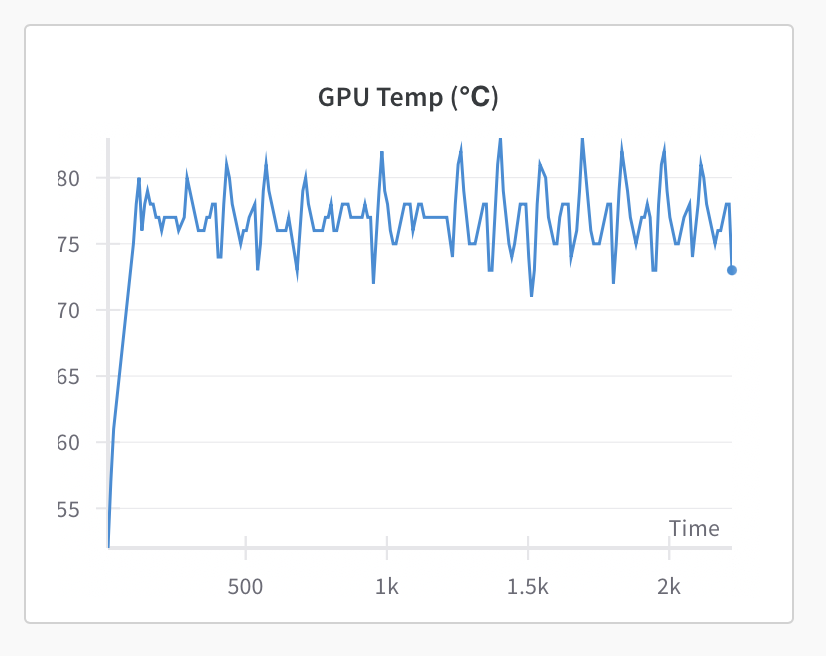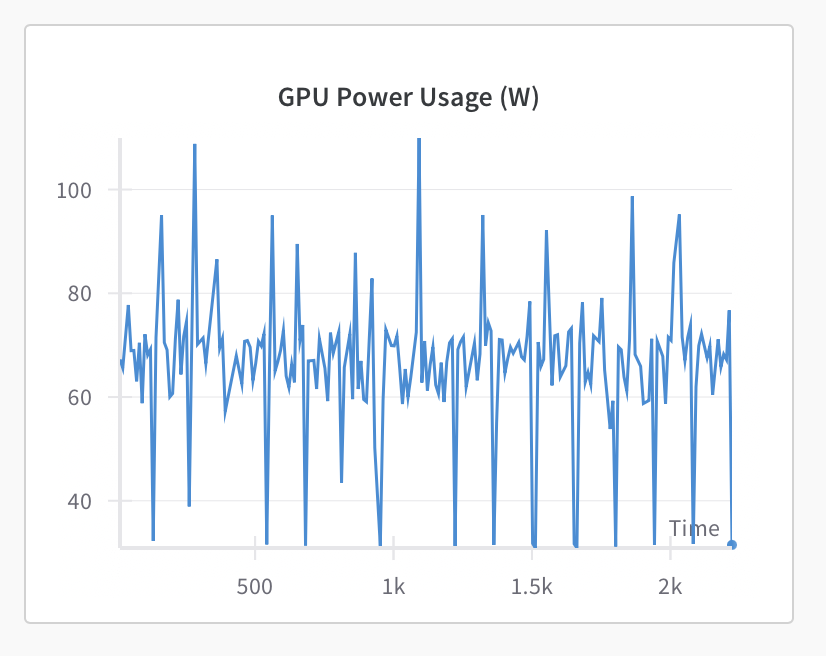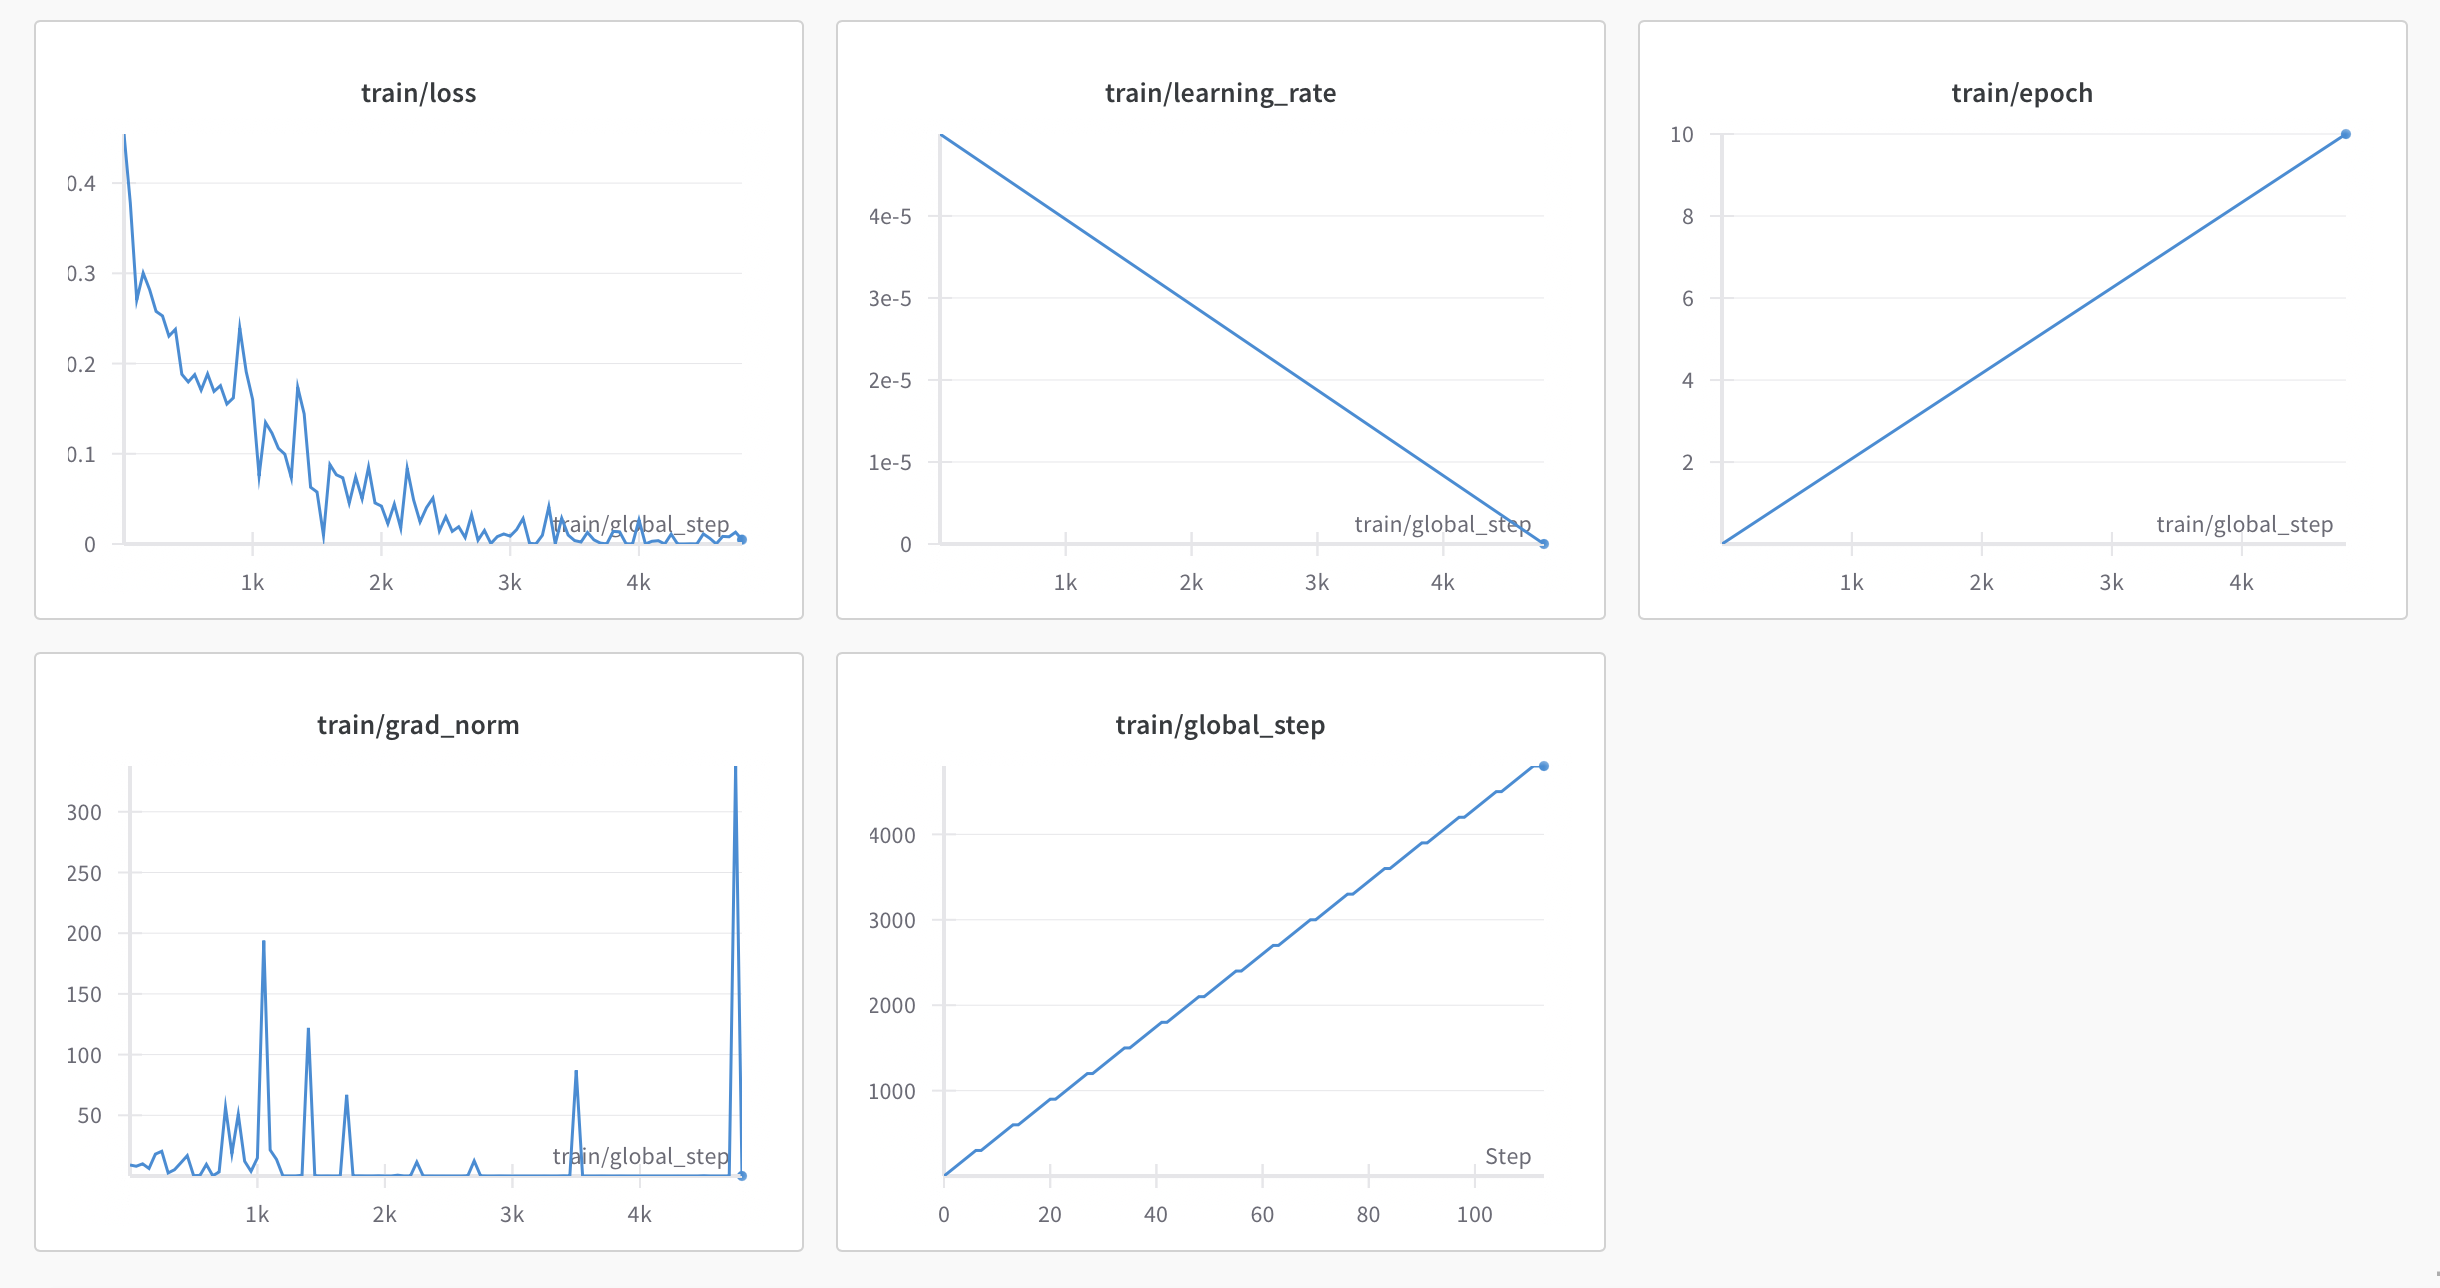

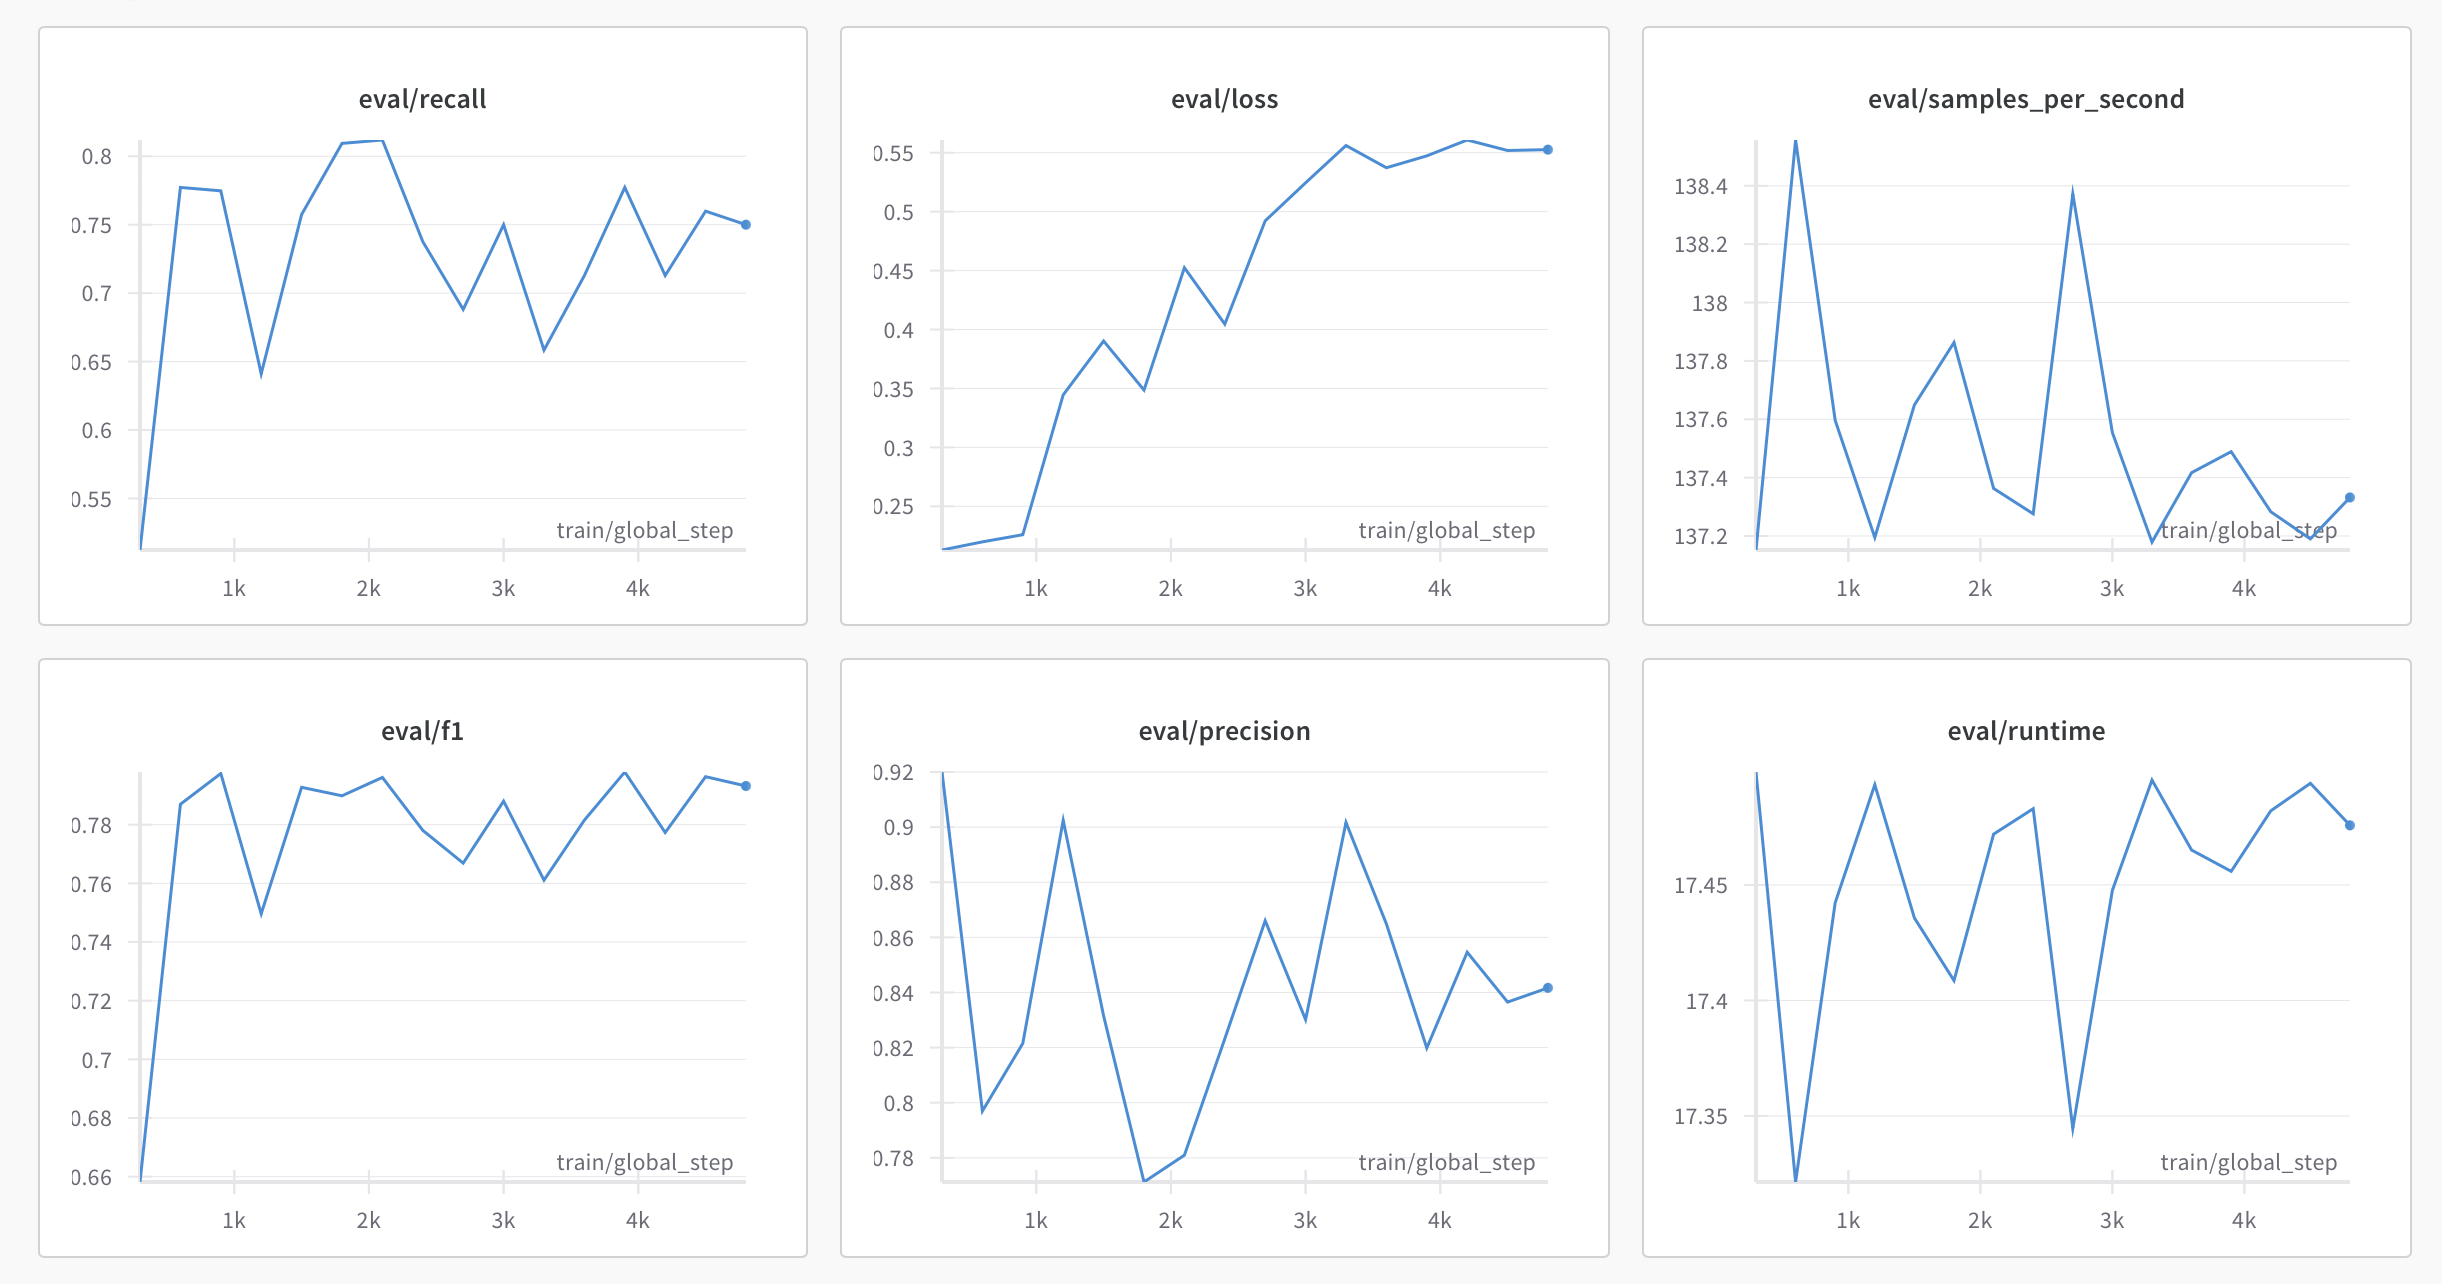

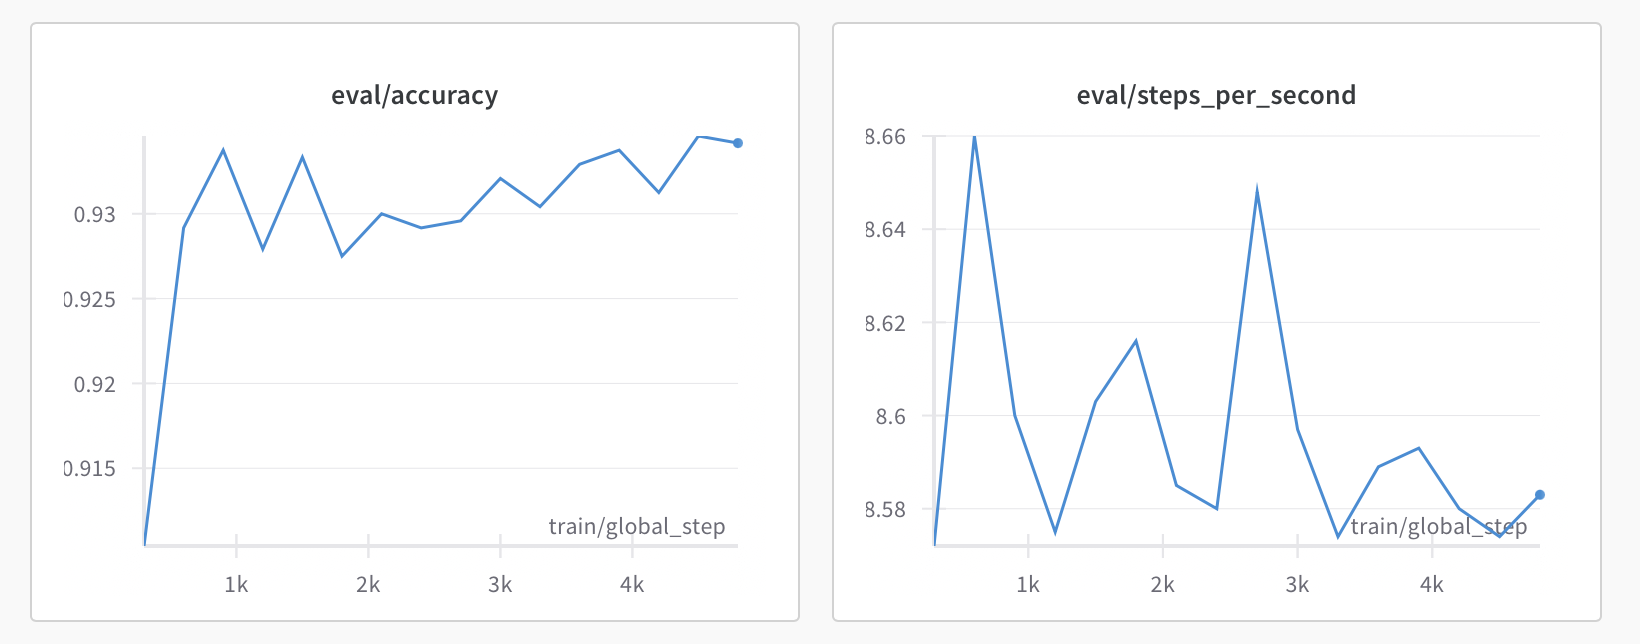

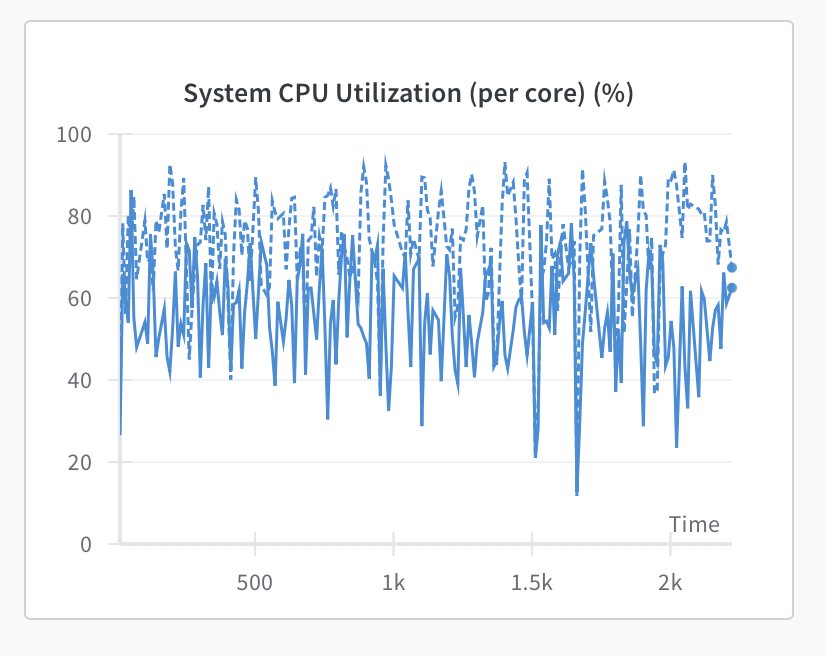

6. Report the results you have obtained for the model. Use appropriate measures, since the dataset is not balanced.

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5518938302993774,
 'eval_accuracy': 0.9345833333333333,
 'eval_precision': 0.8365122615803815,
 'eval_recall': 0.7599009900990099,
 'eval_f1': 0.7963683527885862,
 'eval_runtime': 17.9903,
 'eval_samples_per_second': 133.405,
 'eval_steps_per_second': 8.338,
 'epoch': 10.0}

In [ ]:
model.save_pretrained('./model')
tokenizer.save_pretrained('./model')
!zip -r model.zip ./model

  adding: model/ (stored 0%)
  adding: model/tokenizer.json (deflated 82%)
  adding: model/merges.txt (deflated 60%)
  adding: model/tokenizer_config.json (deflated 76%)
  adding: model/model.safetensors (deflated 11%)
  adding: model/special_tokens_map.json (deflated 53%)
  adding: model/vocab.json (deflated 62%)
  adding: model/config.json (deflated 50%)


In [ ]:
text = df[df['class']==1][6:7]['text'].values[0]
text

'Pytanie: W-8BEN? Jaki jest podatek ze sprzedaży mojego oprogramowania firmie amerykańskiej z zagranicy? Kontekst: Nie należy zakładać firmy w USA tylko po to, aby uzyskać numer identyfikacyjny wymagany do formularza W-8BEN. Zakładając firmę z siedzibą w USA, zapisałbyś się na wiele dodatkowych kłopotów! Nie potrzebujesz tego. Jesteś firmą europejską, a nie amerykańską. Sprzedaż do USA nie wymaga posiadania amerykańskiej firmy. (Możesz jednak zastanowić się, jaką formę działalności powinieneś prowadzić w swoim kraju.) W każdym razie, aby rozwiązać swoje najpilniejsze obawy, powinieneś po prostu uzyskać tylko numer EIN. Zobacz businessready.ca - co to jest W8-BEN?. Cytat: [...] Istnieją inne powody, aby wypełnić formularz W8-BEN, ale dla większości z was jest to upewnienie się, że nie wstrzymują 30% płatności, co dla małej firmy jest dużym problemem . [...] Jak uzyskać jeden z tych numerów identyfikacyjnych podatnika EIN US? EIN to skrót od Employer Identification Number, który jest Two

In [ ]:
classifier = pipeline("sentiment-analysis", model="./model")
classifier(text)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_1', 'score': 0.9999654293060303}]

In [ ]:
from sklearn.metrics import classification_report

test_predictions = trainer.predict(test)
logits, labels = test_predictions.predictions, test_predictions.label_ids
predictions = np.argmax(logits, axis=1)
print(classification_report(labels, predictions, target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.96      0.97      0.97      1604
    positive       0.85      0.79      0.82       316

    accuracy                           0.94      1920
   macro avg       0.90      0.88      0.89      1920
weighted avg       0.94      0.94      0.94      1920


7. Use the classifier as a re-ranker for finding the answers to the questions. Since the re-ranker is slow, you



   have to limit the subset of possible passages to top-n (10, 50 or 100 - depending on your GPU) texts returned by much faster model, e.g. FTS.

8. The scheme for re-ranking is as follows:
   1. Find passage candidates using FTS, where the query is the question.
   2. Take top-n results returned by FTS.
   3. Use the model to classify all pairs, where the first sentence is the question (query) and the second sentence is the passage returned by the FTS.
   4. Use the score returned by the model (i.e. the probability of the **positive** outcome) to re-rank the passages.

In [4]:
tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
model = AutoModelForSequenceClassification.from_pretrained('./model')
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, return_all_scores=True, truncation=True, max_length=512)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
#!pip3 install "numpy<2.x" # or "numpy<2"

In [5]:
from elasticsearch import Elasticsearch

es = Elasticsearch(["http://localhost:9200"])

In [6]:
if es.ping():
    print("Połączono z Elasticsearch.")
else:
    print("Nie udało się połączyć z Elasticsearch.")

Połączono z Elasticsearch.


In [17]:
analyzer_config = {
    "settings": {
        "analysis": {
            "analyzer": {
                "polish_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",  
                    "filter": ["lowercase", "morfologik_stem"]  
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "text": {
                "type": "text",
                "analyzer": "polish_analyzer"
            }
        }
    }
}

if es.indices.exists(index="polish_index"):
    es.indices.delete(index="polish_index")
es.indices.create(index="polish_index", body=analyzer_config)
print("Indeks 'polish_index' został utworzony.")

Indeks 'polish_index' został utworzony.


9. Compute how much the result of searching the passages improved over the results from lab 2. Use NDCG to compare the
results.

In [18]:
dataset = load_dataset("clarin-knext/fiqa-pl", 'corpus')
dataset = pd.DataFrame(dataset['corpus'])
df3 = load_dataset("clarin-knext/fiqa-pl", "queries")
df_queries = pd.DataFrame(df3['queries'])
df2 = load_dataset("clarin-knext/fiqa-pl-qrels")
df_qa_test = pd.DataFrame(df2['test'])

In [19]:
for i, record in enumerate(tqdm(dataset['text'], desc="Indeksowanie dokumentów", unit="dokument")):
    document = {
        "text": record,
    }
    es.index(index="analyzer", id=i, document=document)



query_blank = {
    "match": {
        "text": {
            "query": "blank"
        }
    }
}

Indeksowanie dokumentów: 100%|█████| 57638/57638 [04:11<00:00, 229.46dokument/s]


In [20]:
total_ndcg = 0
processed_queries = 0

def calc_ndcg_k(scores):
    dcg = np.sum(scores / np.log2(np.arange(2, len(scores) + 2)))
    idcg = np.sum(sorted(scores, reverse=True) / np.log2(np.arange(2, len(scores) + 2)))
    ndcg = dcg / idcg if idcg > 0 else 0.0
    return ndcg

print("Przetwarzanie zapytań i obliczanie NDCG (model)...")
for query_id in tqdm(df_qa_test['query-id'].unique(), desc="Zapytania", unit="zapytanie"):
    query = df_queries[df_queries['_id'] == str(query_id)].iloc[0]['text']
    query_blank['match']['text']['query'] = query
    resp = es.search(index="analyzer", query=query_blank)

    data = []
    for val in resp['hits']['hits'][:10]:
        data.append(f"Pytanie: {query} Kontekst: {val['_source']['text']}")

    corpus_ids = df_qa_test[df_qa_test['query-id'] == query_id]['corpus-id']
    tmp = set()
    for ind in corpus_ids:
        _id = dataset[dataset['_id'] == str(ind)].index.tolist()[0]
        tmp.add(_id)

    rank = {}
    for i, text in enumerate(data):
        text = text[:512]
        rank[i] = classifier(text)

    sorted_rank = {
        k: v for k, v in sorted(
            rank.items(),
            key=lambda item: next((x['score'] for x in item[1][0] if x['label'] == 'LABEL_1'), 0),
            reverse=True
        )
    }

    sorted_5 = {k: sorted_rank[k] for k in list(sorted_rank)[:5]}
    arr = np.zeros(5)
    for i, ind in enumerate(sorted_5.keys()):
        val = resp['hits']['hits'][ind]
        _id = np.float64(val['_id'])
        arr[i] = 3 if _id in tmp else 0

    total_ndcg += calc_ndcg_k(arr)
    processed_queries += 1

    if processed_queries % 10 == 0:
        print(f"Przetworzono {processed_queries} zapytań. Bieżący średni NDCG: {total_ndcg / processed_queries:.4f}")

mean_ndcg = total_ndcg / processed_queries
print(f"\nObliczenia zakończone. Średni NDCG z modelem: {mean_ndcg:.4f}")

Przetwarzanie zapytań i obliczanie NDCG (model)...


Zapytania:   2%|▎                       | 10/648 [00:17<17:40,  1.66s/zapytanie]

Przetworzono 10 zapytań. Bieżący średni NDCG: 0.1062


Zapytania:   3%|▋                       | 20/648 [00:36<22:20,  2.13s/zapytanie]

Przetworzono 20 zapytań. Bieżący średni NDCG: 0.0846


Zapytania:   5%|█                       | 30/648 [00:56<18:02,  1.75s/zapytanie]

Przetworzono 30 zapytań. Bieżący średni NDCG: 0.1064


Zapytania:   6%|█▍                      | 40/648 [01:11<14:37,  1.44s/zapytanie]

Przetworzono 40 zapytań. Bieżący średni NDCG: 0.0906


Zapytania:   8%|█▊                      | 50/648 [01:27<15:37,  1.57s/zapytanie]

Przetworzono 50 zapytań. Bieżący średni NDCG: 0.1338


Zapytania:   9%|██▏                     | 60/648 [01:44<17:33,  1.79s/zapytanie]

Przetworzono 60 zapytań. Bieżący średni NDCG: 0.1325


Zapytania:  11%|██▌                     | 70/648 [02:01<18:00,  1.87s/zapytanie]

Przetworzono 70 zapytań. Bieżący średni NDCG: 0.1136


Zapytania:  12%|██▉                     | 80/648 [02:17<15:06,  1.60s/zapytanie]

Przetworzono 80 zapytań. Bieżący średni NDCG: 0.1181


Zapytania:  14%|███▎                    | 90/648 [02:32<14:04,  1.51s/zapytanie]

Przetworzono 90 zapytań. Bieżący średni NDCG: 0.1406


Zapytania:  15%|███▌                   | 100/648 [02:47<14:03,  1.54s/zapytanie]

Przetworzono 100 zapytań. Bieżący średni NDCG: 0.1614


Zapytania:  17%|███▉                   | 110/648 [03:06<16:58,  1.89s/zapytanie]

Przetworzono 110 zapytań. Bieżący średni NDCG: 0.1832


Zapytania:  19%|████▎                  | 120/648 [03:22<15:47,  1.79s/zapytanie]

Przetworzono 120 zapytań. Bieżący średni NDCG: 0.2013


Zapytania:  20%|████▌                  | 130/648 [03:39<13:08,  1.52s/zapytanie]

Przetworzono 130 zapytań. Bieżący średni NDCG: 0.2086


Zapytania:  22%|████▉                  | 140/648 [03:57<15:37,  1.84s/zapytanie]

Przetworzono 140 zapytań. Bieżący średni NDCG: 0.2125


Zapytania:  23%|█████▎                 | 150/648 [04:13<13:29,  1.62s/zapytanie]

Przetworzono 150 zapytań. Bieżący średni NDCG: 0.2016


Zapytania:  25%|█████▋                 | 160/648 [04:28<11:36,  1.43s/zapytanie]

Przetworzono 160 zapytań. Bieżący średni NDCG: 0.2087


Zapytania:  26%|██████                 | 170/648 [04:46<14:33,  1.83s/zapytanie]

Przetworzono 170 zapytań. Bieżący średni NDCG: 0.2023


Zapytania:  28%|██████▍                | 180/648 [05:03<13:05,  1.68s/zapytanie]

Przetworzono 180 zapytań. Bieżący średni NDCG: 0.1954


Zapytania:  29%|██████▋                | 190/648 [05:20<13:57,  1.83s/zapytanie]

Przetworzono 190 zapytań. Bieżący średni NDCG: 0.1910


Zapytania:  31%|███████                | 200/648 [05:36<11:30,  1.54s/zapytanie]

Przetworzono 200 zapytań. Bieżący średni NDCG: 0.1990


Zapytania:  32%|███████▍               | 210/648 [05:52<13:01,  1.78s/zapytanie]

Przetworzono 210 zapytań. Bieżący średni NDCG: 0.1944


Zapytania:  34%|███████▊               | 220/648 [06:08<11:57,  1.68s/zapytanie]

Przetworzono 220 zapytań. Bieżący średni NDCG: 0.1949


Zapytania:  35%|████████▏              | 230/648 [06:25<11:26,  1.64s/zapytanie]

Przetworzono 230 zapytań. Bieżący średni NDCG: 0.1881


Zapytania:  37%|████████▌              | 240/648 [06:38<09:19,  1.37s/zapytanie]

Przetworzono 240 zapytań. Bieżący średni NDCG: 0.1947


Zapytania:  39%|████████▊              | 250/648 [06:52<08:49,  1.33s/zapytanie]

Przetworzono 250 zapytań. Bieżący średni NDCG: 0.1889


Zapytania:  40%|█████████▏             | 260/648 [07:07<09:42,  1.50s/zapytanie]

Przetworzono 260 zapytań. Bieżący średni NDCG: 0.1857


Zapytania:  42%|█████████▌             | 270/648 [07:24<11:05,  1.76s/zapytanie]

Przetworzono 270 zapytań. Bieżący średni NDCG: 0.1880


Zapytania:  43%|█████████▉             | 280/648 [07:41<10:16,  1.68s/zapytanie]

Przetworzono 280 zapytań. Bieżący średni NDCG: 0.1935


Zapytania:  45%|██████████▎            | 290/648 [08:00<11:25,  1.92s/zapytanie]

Przetworzono 290 zapytań. Bieżący średni NDCG: 0.1892


Zapytania:  46%|██████████▋            | 300/648 [08:16<08:29,  1.46s/zapytanie]

Przetworzono 300 zapytań. Bieżący średni NDCG: 0.1921


Zapytania:  48%|███████████            | 310/648 [08:30<08:04,  1.43s/zapytanie]

Przetworzono 310 zapytań. Bieżący średni NDCG: 0.1910


Zapytania:  49%|███████████▎           | 320/648 [08:47<09:32,  1.74s/zapytanie]

Przetworzono 320 zapytań. Bieżący średni NDCG: 0.1890


Zapytania:  51%|███████████▋           | 330/648 [09:02<08:21,  1.58s/zapytanie]

Przetworzono 330 zapytań. Bieżący średni NDCG: 0.1852


Zapytania:  52%|████████████           | 340/648 [09:17<08:07,  1.58s/zapytanie]

Przetworzono 340 zapytań. Bieżący średni NDCG: 0.1856


Zapytania:  54%|████████████▍          | 350/648 [09:34<08:28,  1.70s/zapytanie]

Przetworzono 350 zapytań. Bieżący średni NDCG: 0.1833


Zapytania:  56%|████████████▊          | 360/648 [09:49<06:53,  1.44s/zapytanie]

Przetworzono 360 zapytań. Bieżący średni NDCG: 0.1783


Zapytania:  57%|█████████████▏         | 370/648 [10:04<06:56,  1.50s/zapytanie]

Przetworzono 370 zapytań. Bieżący średni NDCG: 0.1751


Zapytania:  59%|█████████████▍         | 380/648 [10:19<06:05,  1.36s/zapytanie]

Przetworzono 380 zapytań. Bieżący średni NDCG: 0.1781


Zapytania:  60%|█████████████▊         | 390/648 [10:34<06:39,  1.55s/zapytanie]

Przetworzono 390 zapytań. Bieżący średni NDCG: 0.1825


Zapytania:  62%|██████████████▏        | 400/648 [10:50<06:26,  1.56s/zapytanie]

Przetworzono 400 zapytań. Bieżący średni NDCG: 0.1839


Zapytania:  63%|██████████████▌        | 410/648 [11:07<06:17,  1.59s/zapytanie]

Przetworzono 410 zapytań. Bieżący średni NDCG: 0.1833


Zapytania:  65%|██████████████▉        | 420/648 [11:22<05:37,  1.48s/zapytanie]

Przetworzono 420 zapytań. Bieżący średni NDCG: 0.1876


Zapytania:  66%|███████████████▎       | 430/648 [11:36<04:56,  1.36s/zapytanie]

Przetworzono 430 zapytań. Bieżący średni NDCG: 0.1868


Zapytania:  68%|███████████████▌       | 440/648 [11:50<04:41,  1.35s/zapytanie]

Przetworzono 440 zapytań. Bieżący średni NDCG: 0.1862


Zapytania:  69%|███████████████▉       | 450/648 [12:03<04:23,  1.33s/zapytanie]

Przetworzono 450 zapytań. Bieżący średni NDCG: 0.1844


Zapytania:  71%|████████████████▎      | 460/648 [12:20<04:55,  1.57s/zapytanie]

Przetworzono 460 zapytań. Bieżący średni NDCG: 0.1826


Zapytania:  73%|████████████████▋      | 470/648 [12:33<03:48,  1.29s/zapytanie]

Przetworzono 470 zapytań. Bieżący średni NDCG: 0.1798


Zapytania:  74%|█████████████████      | 480/648 [12:50<05:33,  1.98s/zapytanie]

Przetworzono 480 zapytań. Bieżący średni NDCG: 0.1776


Zapytania:  76%|█████████████████▍     | 490/648 [13:07<04:26,  1.69s/zapytanie]

Przetworzono 490 zapytań. Bieżący średni NDCG: 0.1749


Zapytania:  77%|█████████████████▋     | 500/648 [13:27<05:29,  2.23s/zapytanie]

Przetworzono 500 zapytań. Bieżący średni NDCG: 0.1722


Zapytania:  79%|██████████████████     | 510/648 [13:46<04:08,  1.80s/zapytanie]

Przetworzono 510 zapytań. Bieżący średni NDCG: 0.1727


Zapytania:  80%|██████████████████▍    | 520/648 [14:03<03:32,  1.66s/zapytanie]

Przetworzono 520 zapytań. Bieżący średni NDCG: 0.1694


Zapytania:  82%|██████████████████▊    | 530/648 [14:20<03:09,  1.61s/zapytanie]

Przetworzono 530 zapytań. Bieżący średni NDCG: 0.1681


Zapytania:  83%|███████████████████▏   | 540/648 [14:36<02:48,  1.56s/zapytanie]

Przetworzono 540 zapytań. Bieżący średni NDCG: 0.1666


Zapytania:  85%|███████████████████▌   | 550/648 [14:51<02:22,  1.46s/zapytanie]

Przetworzono 550 zapytań. Bieżący średni NDCG: 0.1648


Zapytania:  86%|███████████████████▉   | 560/648 [15:05<02:19,  1.58s/zapytanie]

Przetworzono 560 zapytań. Bieżący średni NDCG: 0.1645


Zapytania:  88%|████████████████████▏  | 570/648 [15:21<02:02,  1.57s/zapytanie]

Przetworzono 570 zapytań. Bieżący średni NDCG: 0.1632


Zapytania:  90%|████████████████████▌  | 580/648 [15:38<01:41,  1.49s/zapytanie]

Przetworzono 580 zapytań. Bieżący średni NDCG: 0.1637


Zapytania:  91%|████████████████████▉  | 590/648 [15:53<01:21,  1.41s/zapytanie]

Przetworzono 590 zapytań. Bieżący średni NDCG: 0.1635


Zapytania:  93%|█████████████████████▎ | 600/648 [16:08<01:13,  1.53s/zapytanie]

Przetworzono 600 zapytań. Bieżący średni NDCG: 0.1637


Zapytania:  94%|█████████████████████▋ | 610/648 [16:24<01:01,  1.62s/zapytanie]

Przetworzono 610 zapytań. Bieżący średni NDCG: 0.1659


Zapytania:  96%|██████████████████████ | 620/648 [16:38<00:40,  1.44s/zapytanie]

Przetworzono 620 zapytań. Bieżący średni NDCG: 0.1639


Zapytania:  97%|██████████████████████▎| 630/648 [16:54<00:28,  1.60s/zapytanie]

Przetworzono 630 zapytań. Bieżący średni NDCG: 0.1623


Zapytania:  99%|██████████████████████▋| 640/648 [17:09<00:12,  1.51s/zapytanie]

Przetworzono 640 zapytań. Bieżący średni NDCG: 0.1628


Zapytania: 100%|███████████████████████| 648/648 [17:21<00:00,  1.61s/zapytanie]


Obliczenia zakończone. Średni NDCG z modelem: 0.1655


In [21]:
total_ndcg = 0
processed_queries = 0

print("Przetwarzanie zapytań i obliczanie NDCG (base results)...")
for query_id in tqdm(df_qa_test['query-id'].unique(), desc="Zapytania", unit="zapytanie"):
    query = df_queries[df_queries['_id'] == str(query_id)].iloc[0]['text']
    query_blank['match']['text']['query'] = query
    resp = es.search(index="analyzer", query=query_blank)

    corpus_ids = df_qa_test[df_qa_test['query-id'] == query_id]['corpus-id']
    tmp = set()
    for ind in corpus_ids:
        _id = dataset[dataset['_id'] == str(ind)].index.tolist()[0]
        tmp.add(_id)

    arr = np.zeros(5)
    for i, val in enumerate(resp['hits']['hits'][:5]):
        _id = np.float64(val['_id'])
        arr[i] = 1 if _id in tmp else 0

    total_ndcg += calc_ndcg_k(arr)
    processed_queries += 1

    if processed_queries % 10 == 0:
        print(f"Przetworzono {processed_queries} zapytań. Bieżący średni NDCG: {total_ndcg / processed_queries:.4f}")

mean_ndcg = total_ndcg / processed_queries
print(f"\nObliczenia zakończone. Średni NDCG bez modelu (base results): {mean_ndcg:.4f}")

Przetwarzanie zapytań i obliczanie NDCG (base results)...


Zapytania:   3%|▋                       | 17/648 [00:00<00:18, 34.57zapytanie/s]

Przetworzono 10 zapytań. Bieżący średni NDCG: 0.1500


Zapytania:   4%|▉                       | 26/648 [00:00<00:16, 37.99zapytanie/s]

Przetworzono 20 zapytań. Bieżący średni NDCG: 0.1250


Zapytania:   5%|█▎                      | 34/648 [00:01<00:20, 29.72zapytanie/s]

Przetworzono 30 zapytań. Bieżący średni NDCG: 0.1044


Zapytania:   6%|█▍                      | 39/648 [00:01<00:18, 32.74zapytanie/s]

Przetworzono 40 zapytań. Bieżący średni NDCG: 0.1033


Zapytania:   8%|█▉                      | 51/648 [00:02<00:55, 10.77zapytanie/s]

Przetworzono 50 zapytań. Bieżący średni NDCG: 0.1503


Zapytania:  10%|██▎                     | 64/648 [00:03<00:27, 20.99zapytanie/s]

Przetworzono 60 zapytań. Bieżący średni NDCG: 0.1577


Zapytania:  12%|██▊                     | 77/648 [00:03<00:19, 28.70zapytanie/s]

Przetworzono 70 zapytań. Bieżący średni NDCG: 0.1414


Zapytania:  12%|███                     | 81/648 [00:03<00:21, 26.30zapytanie/s]

Przetworzono 80 zapytań. Bieżący średni NDCG: 0.1495


Zapytania:  14%|███▍                    | 93/648 [00:04<00:23, 23.28zapytanie/s]

Przetworzono 90 zapytań. Bieżący średni NDCG: 0.1820


Zapytania:  16%|███▋                   | 104/648 [00:04<00:20, 26.90zapytanie/s]

Przetworzono 100 zapytań. Bieżący średni NDCG: 0.2148


Zapytania:  18%|████                   | 114/648 [00:04<00:21, 24.59zapytanie/s]

Przetworzono 110 zapytań. Bieżący średni NDCG: 0.2169


Zapytania:  19%|████▎                  | 123/648 [00:05<00:22, 23.12zapytanie/s]

Przetworzono 120 zapytań. Bieżący średni NDCG: 0.2228


Zapytania:  21%|████▊                  | 135/648 [00:05<00:19, 26.87zapytanie/s]

Przetworzono 130 zapytań. Bieżący średni NDCG: 0.2288


Zapytania:  22%|█████▏                 | 145/648 [00:06<00:17, 28.15zapytanie/s]

Przetworzono 140 zapytań. Bieżący średni NDCG: 0.2196


Zapytania:  24%|█████▍                 | 153/648 [00:06<00:18, 27.17zapytanie/s]

Przetworzono 150 zapytań. Bieżący średni NDCG: 0.2078


Zapytania:  25%|█████▊                 | 165/648 [00:06<00:16, 29.40zapytanie/s]

Przetworzono 160 zapytań. Bieżący średni NDCG: 0.2218


Zapytania:  27%|██████▏                | 176/648 [00:07<00:16, 28.49zapytanie/s]

Przetworzono 170 zapytań. Bieżący średni NDCG: 0.2206


Zapytania:  28%|██████▌                | 184/648 [00:07<00:15, 29.26zapytanie/s]

Przetworzono 180 zapytań. Bieżący średni NDCG: 0.2229


Zapytania:  30%|██████▊                | 192/648 [00:07<00:14, 30.62zapytanie/s]

Przetworzono 190 zapytań. Bieżący średni NDCG: 0.2174


Zapytania:  31%|███████▏               | 204/648 [00:08<00:14, 30.15zapytanie/s]

Przetworzono 200 zapytań. Bieżący średni NDCG: 0.2240


Zapytania:  33%|███████▌               | 214/648 [00:08<00:15, 27.54zapytanie/s]

Przetworzono 210 zapytań. Bieżący średni NDCG: 0.2228


Zapytania:  35%|███████▉               | 224/648 [00:08<00:15, 26.79zapytanie/s]

Przetworzono 220 zapytań. Bieżący średni NDCG: 0.2237


Zapytania:  36%|████████▎              | 233/648 [00:09<00:17, 23.84zapytanie/s]

Przetworzono 230 zapytań. Bieżący średni NDCG: 0.2205


Zapytania:  38%|████████▋              | 244/648 [00:09<00:15, 25.59zapytanie/s]

Przetworzono 240 zapytań. Bieżący średni NDCG: 0.2277


Zapytania:  39%|████████▉              | 253/648 [00:10<00:21, 18.51zapytanie/s]

Przetworzono 250 zapytań. Bieżący średni NDCG: 0.2226


Zapytania:  41%|█████████▍             | 265/648 [00:10<00:14, 25.83zapytanie/s]

Przetworzono 260 zapytań. Bieżący średni NDCG: 0.2203


Zapytania:  42%|█████████▌             | 271/648 [00:11<00:15, 23.78zapytanie/s]

Przetworzono 270 zapytań. Bieżący średni NDCG: 0.2242


Zapytania:  44%|██████████▏            | 286/648 [00:11<00:12, 28.40zapytanie/s]

Przetworzono 280 zapytań. Bieżący średni NDCG: 0.2301


Zapytania:  45%|██████████▎            | 292/648 [00:11<00:13, 27.04zapytanie/s]

Przetworzono 290 zapytań. Bieżący średni NDCG: 0.2269


Zapytania:  47%|██████████▊            | 305/648 [00:12<00:12, 27.66zapytanie/s]

Przetworzono 300 zapytań. Bieżący średni NDCG: 0.2269


Zapytania:  49%|███████████▏           | 316/648 [00:12<00:10, 32.03zapytanie/s]

Przetworzono 310 zapytań. Bieżący średni NDCG: 0.2265


Zapytania:  50%|███████████▌           | 326/648 [00:12<00:08, 37.92zapytanie/s]

Przetworzono 320 zapytań. Bieżący średni NDCG: 0.2235


Zapytania:  52%|███████████▉           | 335/648 [00:13<00:07, 39.52zapytanie/s]

Przetworzono 330 zapytań. Bieżący średni NDCG: 0.2206


Zapytania:  53%|████████████▏          | 343/648 [00:13<00:09, 31.27zapytanie/s]

Przetworzono 340 zapytań. Bieżący średni NDCG: 0.2200


Zapytania:  55%|████████████▌          | 355/648 [00:13<00:09, 30.66zapytanie/s]

Przetworzono 350 zapytań. Bieżący średni NDCG: 0.2194


Zapytania:  56%|████████████▉          | 363/648 [00:14<00:09, 29.92zapytanie/s]

Przetworzono 360 zapytań. Bieżący średni NDCG: 0.2133


Zapytania:  58%|█████████████▍         | 377/648 [00:14<00:07, 34.68zapytanie/s]

Przetworzono 370 zapytań. Bieżący średni NDCG: 0.2130


Zapytania:  59%|█████████████▋         | 385/648 [00:14<00:08, 31.29zapytanie/s]

Przetworzono 380 zapytań. Bieżący średni NDCG: 0.2161


Zapytania:  60%|█████████████▉         | 392/648 [00:15<00:11, 22.33zapytanie/s]

Przetworzono 390 zapytań. Bieżący średni NDCG: 0.2173


Zapytania:  62%|██████████████▏        | 401/648 [00:15<00:11, 21.40zapytanie/s]

Przetworzono 400 zapytań. Bieżący średni NDCG: 0.2221


Zapytania:  64%|██████████████▊        | 416/648 [00:16<00:08, 27.81zapytanie/s]

Przetworzono 410 zapytań. Bieżący średni NDCG: 0.2216


Zapytania:  65%|███████████████        | 424/648 [00:16<00:07, 29.63zapytanie/s]

Przetworzono 420 zapytań. Bieżący średni NDCG: 0.2229


Zapytania:  67%|███████████████▌       | 437/648 [00:16<00:06, 34.83zapytanie/s]

Przetworzono 430 zapytań. Bieżący średni NDCG: 0.2235


Zapytania:  69%|███████████████▊       | 445/648 [00:16<00:05, 36.04zapytanie/s]

Przetworzono 440 zapytań. Bieżący średni NDCG: 0.2258


Zapytania:  70%|████████████████▏      | 455/648 [00:17<00:04, 41.28zapytanie/s]

Przetworzono 450 zapytań. Bieżący średni NDCG: 0.2277


Zapytania:  72%|████████████████▌      | 465/648 [00:17<00:04, 38.41zapytanie/s]

Przetworzono 460 zapytań. Bieżący średni NDCG: 0.2250


Zapytania:  73%|████████████████▊      | 475/648 [00:17<00:04, 40.52zapytanie/s]

Przetworzono 470 zapytań. Bieżący średni NDCG: 0.2202


Zapytania:  75%|█████████████████▏     | 485/648 [00:17<00:04, 35.37zapytanie/s]

Przetworzono 480 zapytań. Bieżący średni NDCG: 0.2177


Zapytania:  76%|█████████████████▌     | 494/648 [00:18<00:04, 34.85zapytanie/s]

Przetworzono 490 zapytań. Bieżący średni NDCG: 0.2173


Zapytania:  78%|█████████████████▉     | 506/648 [00:18<00:04, 35.05zapytanie/s]

Przetworzono 500 zapytań. Bieżący średni NDCG: 0.2160


Zapytania:  79%|██████████████████▏    | 514/648 [00:18<00:04, 32.56zapytanie/s]

Przetworzono 510 zapytań. Bieżący średni NDCG: 0.2169


Zapytania:  81%|██████████████████▌    | 523/648 [00:19<00:03, 34.54zapytanie/s]

Przetworzono 520 zapytań. Bieżący średni NDCG: 0.2127


Zapytania:  83%|██████████████████▉    | 535/648 [00:19<00:03, 31.26zapytanie/s]

Przetworzono 530 zapytań. Bieżący średni NDCG: 0.2094


Zapytania:  84%|███████████████████▎   | 543/648 [00:19<00:03, 31.41zapytanie/s]

Przetworzono 540 zapytań. Bieżący średni NDCG: 0.2100


Zapytania:  86%|███████████████████▋   | 555/648 [00:20<00:02, 31.40zapytanie/s]

Przetworzono 550 zapytań. Bieżący średni NDCG: 0.2078


Zapytania:  87%|███████████████████▉   | 563/648 [00:20<00:02, 32.19zapytanie/s]

Przetworzono 560 zapytań. Bieżący średni NDCG: 0.2086


Zapytania:  89%|████████████████████▍  | 575/648 [00:20<00:02, 33.49zapytanie/s]

Przetworzono 570 zapytań. Bieżący średni NDCG: 0.2075


Zapytania:  90%|████████████████████▋  | 583/648 [00:20<00:01, 35.63zapytanie/s]

Przetworzono 580 zapytań. Bieżący średni NDCG: 0.2081


Zapytania:  92%|█████████████████████  | 594/648 [00:21<00:01, 40.44zapytanie/s]

Przetworzono 590 zapytań. Bieżący średni NDCG: 0.2073


Zapytania:  93%|█████████████████████▍ | 604/648 [00:21<00:01, 41.40zapytanie/s]

Przetworzono 600 zapytań. Bieżący średni NDCG: 0.2083


Zapytania:  95%|█████████████████████▊ | 614/648 [00:21<00:00, 36.60zapytanie/s]

Przetworzono 610 zapytań. Bieżący średni NDCG: 0.2096


Zapytania:  97%|██████████████████████▏| 626/648 [00:22<00:00, 32.73zapytanie/s]

Przetworzono 620 zapytań. Bieżący średni NDCG: 0.2079


Zapytania:  98%|██████████████████████▌| 634/648 [00:22<00:00, 32.63zapytanie/s]

Przetworzono 630 zapytań. Bieżący średni NDCG: 0.2061


Zapytania: 100%|██████████████████████▉| 647/648 [00:22<00:00, 34.99zapytanie/s]

Przetworzono 640 zapytań. Bieżący średni NDCG: 0.2074


Zapytania: 100%|███████████████████████| 648/648 [00:22<00:00, 28.62zapytanie/s]


Obliczenia zakończone. Średni NDCG bez modelu (base results): 0.2078


Obliczenia zakończone. Średni NDCG z modelem: 0.1655
Obliczenia zakończone. Średni NDCG bez modelu (base results): 0.2078
The results indicate that the model does not improve ranking performance, as the Mean NDCG with the model (0.1655) is lower than the base results (0.2078). This suggests that the model may not be well-tuned for the task or that Elasticsearch's default ranking already performs effectively.

**Questions (2 points):**

**Do you think simpler methods, like Bayesian bag-of-words model, would work for sentence-pair classification? Justify your answer.**

I think simpler methods like a Bayesian bag-of-words model could work for sentence-pair classification in some cases, but they are likely to perform worse than more advanced methods like Transformers. Bag-of-words models ignore word order and context, which are crucial for understanding the relationship between two sentences. For example, recognizing paraphrases or entailment often requires capturing subtle semantic nuances and dependencies, which bag-of-words models cannot effectively do. However, for tasks with clear keyword-based relationships and less emphasis on syntax or context, a Bayesian bag-of-words model might provide a reasonable baseline.

**What hyper-parameters you have selected for the training? What resources (papers, tutorial) you have consulted to select these hyper-parameters?**

training_args = TrainingArguments(
    output_dir="./output",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    eval_steps=300,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-05,
    num_train_epochs=10,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="steps",
    save_steps=300,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

For training, I used a learning rate of 5e-5, which is commonly recommended for fine-tuning Transformer-based models like BERT or Herbert. The batch size was set to 16 for both training and evaluation to balance GPU memory usage and efficiency, and the model was trained for 10 epochs with early stopping to prevent overfitting. I also configured the training to evaluate every 300 steps and save the model at the same interval, ensuring that the best model (based on accuracy) was loaded at the end. Logging was done every 50 steps to monitor progress. These hyper-parameters were inspired by recommendations from the Hugging Face documentation (https://github.com/huggingface/transformers/blob/main/docs/source/en/trainer.md) and an article on fine-tuning with TrainingArguments (https://www.restack.io/p/fine-tuning-answer-trainingarguments-cat-ai), as well as insights from community discussions and tutorials on fine-tuning models for Polish NLP tasks.

**Think about pros and cons of the neural-network models with respect to natural language processing. Provide at least 2 pros and 2 cons.**

Pros:
1. Neural network models are good at capturing complex patterns and contextual relationships in text, which makes them highly effective for tasks like sentiment analysis, machine translation, and question answering.
2. They enable the use of transfer learning, where pre-trained models can be fine-tuned for specific tasks, saving time and computational resources while achieving high performance.

Cons:
1. Neural networks require significant computational resources, which can make them costly and less accessible.
2. They often act as "black boxes," making it difficult to interpret their outputs, which is a drawback for applications requiring explainability and transparency.

## Hints
1. You can use [this notebook](https://github.com/apohllo/sztuczna-inteligencja/tree/master/lab5) as a skeleton for the training procedure. The relevant code starts in the "Klasyfikacja tekstu" section.
2. You can use [Google colab](https://colab.research.google.com/notebooks/intro.ipynb) to perform experiments which require access to GPU or TPU.
3. [Huggingface Transformers](https://github.com/huggingface/transformers) library is a popular library for performing NLP tasks base on the transformer architecture.
4. [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/) by Jurafsky and Martin has a [chapter](https://web.stanford.edu/~jurafsky/slp3/4.pdf) devoted to the problem of classification.
5. [Huggingface course](https://huggingface.co/course/chapter1/1) is a great resource related to all necessary knowledge related to the most up-to-date NLP model training.